In [1]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import pandas as pd

TS = 48 # Time steps

df = pd.read_csv('AusGrid_preprocess.csv', header=[0,1], index_col=0)
df = df.set_index(pd.to_datetime(df.index))
df.columns = df.columns.set_levels(df.columns.levels[0].astype('int64'), level=0)
df = df/1000.
df.head()

Customer             1                  3                4                  \
categories            GG     GC     CL   GG     GC   CL   GG     GC     CL   
2012-07-01 00:30:00  0.0  1.710  2.500  0.0  1.930  0.0  0.0  0.168  0.000   
2012-07-01 01:00:00  0.0  1.572  2.500  0.0  1.854  0.0  0.0  0.168  0.000   
2012-07-01 01:30:00  0.0  1.208  2.500  0.0  2.718  0.0  0.0  0.164  3.860   
2012-07-01 02:00:00  0.0  1.088  2.526  0.0  0.120  0.0  0.0  0.168  3.956   
2012-07-01 02:30:00  0.0  1.194  0.262  0.0  0.118  0.0  0.0  0.172  1.568   

Customer             5    ...  297               298         299         300  \
categories            GG  ...   GG     GC    CL   GG     GC   GG     GC   GG   
2012-07-01 00:30:00  0.0  ...  0.0  0.282  0.00  0.0  0.314  0.0  1.082  0.0   
2012-07-01 01:00:00  0.0  ...  0.0  0.514  0.00  0.0  0.254  0.0  0.200  0.0   
2012-07-01 01:30:00  0.0  ...  0.0  0.394  0.00  0.0  0.244  0.0  0.180  0.0   
2012-07-01 02:00:00  0.0  ...  0.0  0.546  2.66  0.0  0.240  0.0  0.188  0.0   
2012-07-01 02:30:00  0.0  ...  0.0  0.412  0.00  0.0  0.212  0.0  0.092  0.0   

Customer                           
categories              GC     CL  
2012-07-01 00:30:00  0.438  5.346  
2012-07-01 01:00:00  0.198  2.492  
2012-07-01 01:30:00  0.268  0.000  
2012-07-01 02:00:00  0.200  0.000  
2012-07-01 02:30:00  0.246  0.000  

[5 rows x 725 columns]

In [3]:
customers = sorted(df.columns.levels[0])
data_train = []
samples = [201, 202, 203]
for s in samples:
    train = df[s][['GG', 'GC']]
    train['GC'].values[1]
    print(train.shape)
    data_train.append(train)

(17520, 2)
(17520, 2)
(17520, 2)


State : [PV.gen, LD, PV.charge, PV.dischare, BS, GD]
- PV.gen : PV generatoin power
- LD : Load consumption power
- PV.charge : Battery charging power
- PV.dischare : Battery discharging power
- BS : Battery status
- GD : Grid imort(+)/export(-) power

Action : [0, 1]
- 0 : discharging
- 1 : charging

Cost funciton(Reward)
- Self consumption : (PV - PV.charge + PV.dischare - GD) / PV
- Self sufficency : (PV - PV.charge + PV.dischare - GD) / LD

In [4]:
class Environment:
    def __init__(self, data_env, capacity=50.):
        self.capacity = capacity
        self.data_env = data_env
        self.pos = 0
        self.terminated = False
        self.state = np.array([self.data_env['GG'].values[self.pos], self.data_env['GC'].values[self.pos], 0., 0., 0., 0.])

    def reset(self):
        self.state = np.array([0., 0., 0., 0., 0., 0.])
        return torch.as_tensor(self.state, dtype=torch.float32).squeeze(0)

    def step(self, action):
        charging = 0.0
        discharging = 0.0
        batt_state = 0.0
        grid_state = 0.0
        reward = 0.
        
        if action == 1: # charge battery
            charging = max(0, self.state[0] - self.state[1])  # Charging power
            charging = min(self.capacity - self.state[4], charging)
            batt_state = charging # Update battery status
            # if self.state[0] > self.state[1]:
            #     reward = 1.
        elif action == 0: # discharge battery
            discharging = min(self.state[4], max(0, self.state[1] - self.state[0])) # discharing power
            batt_state = -discharging # Update battery status
            # if self.state[0] < self.state[1]:
            #     reward = 1.
            
        grid_state = self.state[1] - (self.state[0] - charging + discharging) # Grid power + : import, - : export

        normal_v = abs(self.state[0] - self.state[1])
        # lgc = self.state[0] - charging + discharging
        lgc = self.state[1] - max(0, grid_state)
        SC = lgc / self.state[0] if self.state[0] else 0
        SS = lgc / self.state[1] if self.state[1] else 0
        # reward = SC + SS - abs(grid_state)
        d = abs(grid_state) / normal_v if normal_v else abs(grid_state)
        reward = min(3, np.log(1/d)) if d else 3
        # reward = -(grid_state/max(self.state[0], self.state[1]))**2
        
        self.state[0] = self.data_env['GG'].values[self.pos]  # PV generation power
        self.state[1] = self.data_env['GC'].values[self.pos]  # Load consumption power
        self.state[2] = charging
        self.state[3] = discharging
        self.state[4] += batt_state
        self.state[5] = grid_state

        self.terminated = False
        self.pos += 1

        return torch.as_tensor(self.state, dtype=torch.float32), torch.tensor([reward]), self.terminated 

    def render(self):
        return 0
    

In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

n_observaons = 6
print(n_observaons)
n_actions = 2
policy_net = DQN(n_observaons, n_actions).to(device)
target_net = DQN(n_observaons, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

6


<All keys matched successfully>

In [7]:
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    return policy_net(state).max(1).indices.view(1, 1)

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


In [8]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

In [9]:
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

In [19]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return 0

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
        
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer.step()

    return loss.item()

    

In [ ]:
def Action(x):
    if x.item() == 1:
        return "Charge"
    elif x.item() == 0:
        return "Discharge"
    else:
        return "None"
    
loss_list = []
num_episodes = 3

for i_episode in range(num_episodes):
    epMemory = list()

    # z = random.randrange(-10, 100)
    # setPoint = random.randrange(math.floor(min(data['y'])), math.ceil(max(data['y'])))
    env = Environment(data_train[i_episode%len(data_train)])
    state = env.reset()    
    state = torch.tensor(state).unsqueeze(0)

    loss_value = 0.0
        
    for t in count():
        action = select_action(state)
        observation, reward, done=env.step(action.item())
        reward = torch.tensor([reward], device=device)

        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        # print(t, ' Action : ', action, 's : ', state, 'ns : ', next_state, 'reward :', round(reward.item(), 2))
        
        # epMemory.append([state, action, next_state, reward])
        memory.push(torch.as_tensor(state), action, next_state, reward)
        state = next_state

        loss_value += optimize_model()
                
        if done:
            if env.render() >= -10 and env.render() <= 100:
                # _ = [memory.push(epMemory[i][0], epMemory[i][1], epMemory[i][2], epMemory[i][3]) for i in range(len(epMemory))]
                print('Success!!')
            else:
                print('Fail!!')
            break

        if t >= env.data_env.shape[0]-1:
            print('Terminated!!')
            break

    loss_list.append(loss_value/len(data_train[i_episode]))
    
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print('Complete!!')

/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1924/1657703236.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1924/1657703236.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


Terminated!!
Complete!!
Terminated!!
Complete!!
Terminated!!
Complete!!


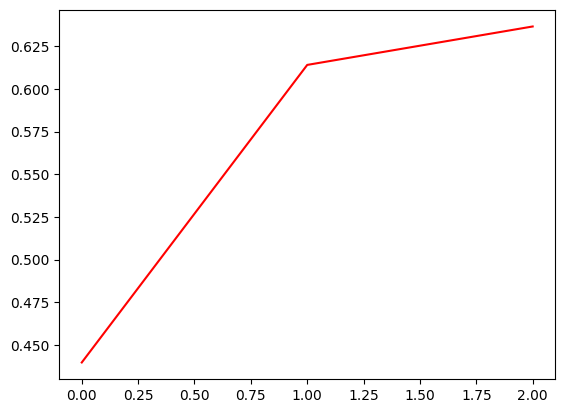

In [27]:
plt.plot(np.array(loss_list), 'r')
plt.show()

In [12]:
customers = sorted(df.columns.levels[0])
data_test = df[1][['GG', 'GC']]
data_test['GC'].values[1]
data_test.shape

(17520, 2)

In [13]:
env = Environment(data_test)
state = torch.tensor(np.array([data_test['GG'].values[0], data_test['GC'].values[0], 0., 0., 0., 0.]), dtype=torch.float32).squeeze(0)
df_out = pd.DataFrame(columns=['PV', 'LD', 'PV.C', 'PV.D', 'BT', 'GD', 'AC', 'RD'])
state = state.clone().detach().unsqueeze(0)

with torch.no_grad():

    for t in count():
        action = select_action(state)
        observation, reward, done=env.step(action.item())
        reward = torch.tensor([reward], device=device)
        next_state = observation.clone().detach().unsqueeze(0)
        st = next_state.numpy().squeeze(0)
        at = action.item()
        # print('Current x : ', t, 'Action :', at, ', y : ', next_state, 'reward :', reward.item())

        st = np.concatenate((st, np.array([at-1, reward.item()])))
        df_out.loc[t] = st
        state = next_state
        if done:
            if env.render() >= -10 and env.render() <= 100:
                print('Success!!')
            else:
                print('Fail!!!')
            break  

        if t >= env.data_env.shape[0]-1:
            print('Terminated!!')
            break  

Terminated!!


      PV     LD  PV.C  PV.D   BT     GD   AC   RD
0    0.0  1.710   0.0   0.0  0.0  1.710 -1.0  0.0
1    0.0  1.572   0.0   0.0  0.0  1.710 -1.0  0.0
2    0.0  1.208   0.0   0.0  0.0  1.572 -1.0  0.0
3    0.0  1.088   0.0   0.0  0.0  1.208 -1.0  0.0
4    0.0  1.194   0.0   0.0  0.0  1.088 -1.0  0.0
..   ...    ...   ...   ...  ...    ...  ...  ...
236  0.0  0.828   0.0   0.0  0.0  0.924 -1.0  0.0
237  0.0  1.864   0.0   0.0  0.0  0.828 -1.0  0.0
238  0.0  0.140   0.0   0.0  0.0  1.864 -1.0  0.0
239  0.0  0.188   0.0   0.0  0.0  0.140 -1.0  0.0
240  0.0  0.112   0.0   0.0  0.0  0.188 -1.0  0.0

[241 rows x 8 columns]


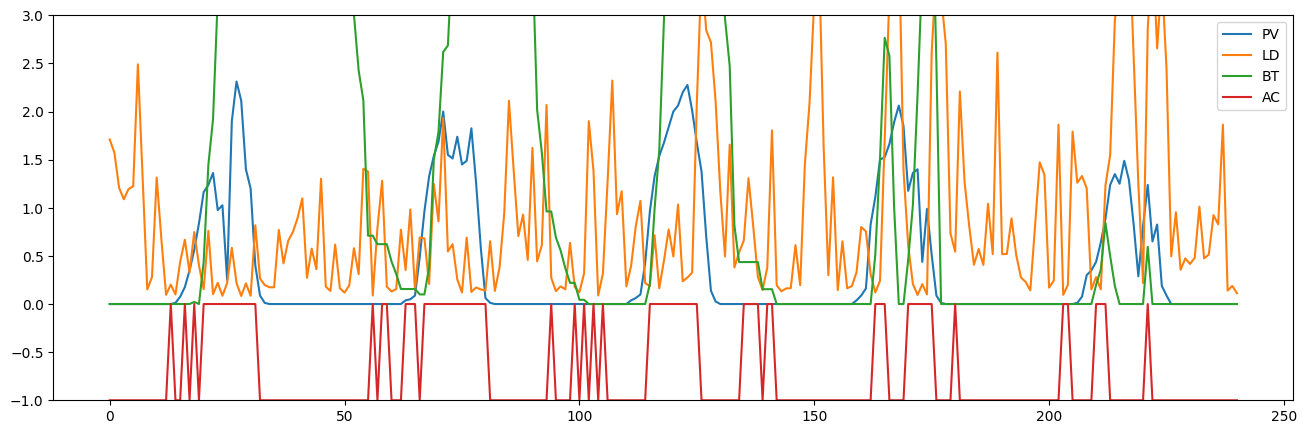

In [14]:
start_pos = 0
duration = 48*5
ax = df_out[['PV', 'LD', 'BT', 'AC']].loc[start_pos:start_pos+duration].plot(figsize=(16,5))
ax.set_ylim(-1, 3)
print(df_out.loc[start_pos:start_pos+duration])
plt.show()

<Axes: >

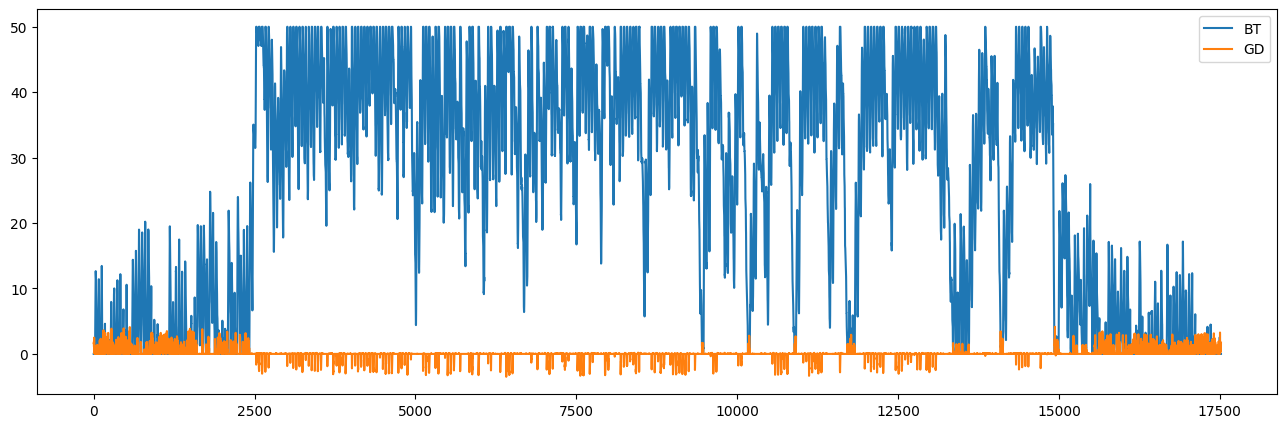

In [15]:
df_out[['BT', 'GD']].plot(figsize=(16,5))

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
 
max_len = len(df_out)

pv =  df_out['PV'].iloc[:].values
ld =  df_out['LD'].iloc[:].values
bt =  df_out['BT'].iloc[:].values
ac =  df_out['AC'].iloc[:].values

def interactive_plot(window, start):    
    window *= 48
    start *= 48
    fig, ax1 = plt.subplots(figsize=(16, 5))    
    ax1.plot(pv, label='PV', color='#1f77b4')
    ax1.plot(ld, label='LD', color='#ff7f0e')
    ax1.plot(ac, label='AC', color='#d62728')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(bt, label='BT', color='#2ca02c')
    ax2.legend(loc='upper right')
    
    start = min(start, max_len-window)
    ax1.set_xlim(start, start+window)
    
    plt.show()

 
 
interact(interactive_plot, window=(1, 10, 1), start=(0, 365, 1))

interactive(children=(IntSlider(value=5, description='window', max=10, min=1), IntSlider(value=182, descriptio…

<function __main__.interactive_plot(window, start)>

In [17]:
Egen = df_out['PV'].sum()
print(Egen, 'KW')
Eload = df_out['LD'].sum()
print(Eload, 'KW')
GDimport = df_out[df_out['GD'] > 0]['GD'].sum()
print(GDimport)
GDexport = df_out[df_out['GD'] < 0]['GD'].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Egen + GDexport)/Eload
print('SC :', SC)
print('SS :', SS)

10230.414012374356 KW
10559.768004506826 KW
2073.5300024603494
-1743.727998428978
SC : 0.8295545032371295
SS : 0.8036811045776127
